# 3 dimensional matching / 3х-мерное сочетание

In [1]:
import random
from IPython.core.display import SVG, HTML
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
import re
from pathlib import Path
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)


## Постановка задачи

«3DM», «3-мерное сопоставление» представляет собой обобщение «задачи о максимальном паросочетании» на 3х-дольные гиперграфы, которые состоят из гиперребер, каждое из которых содержит 3 вершины (вместо ребер, содержащих 2 вершины в случае обычного графа).

Задача состоит в поиске наибольшего трехмерного сопоставления в заданном гиперграфе. 3DM — одна из первых задач, которые оказались NP-сложными. 

https://en.wikipedia.org/wiki/3-dimensional_matching



In [2]:
matchings3d = [
        [0, 'b', 77],
        [1, 'a', 88],
        [1, 'b', 12],
        [1, 'c', 12],
        [2, 'a', 12],
        [3, 'c', 77],
        [2, 'b', 12]
]


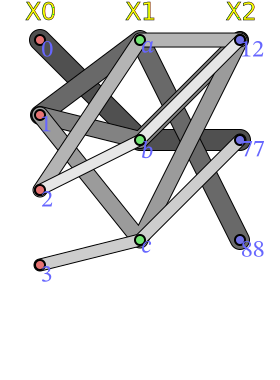

In [3]:
svg = psc.matchings2svg(matchings3d)
SVG(data=svg)

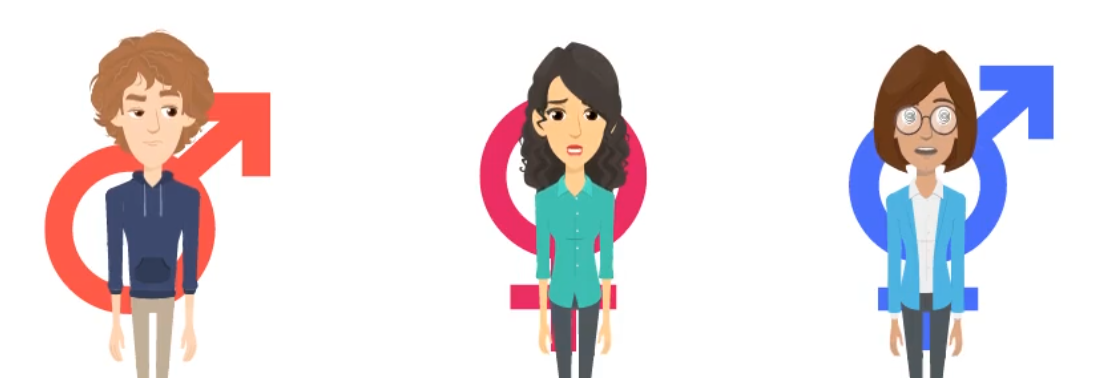

## Реализация в Pyomo

In [4]:
def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

In [5]:
def get_model(matchings3d):
    m = pyo.ConcreteModel()
    m.E = [ (e[0], e[1], e[2]) for e in matchings3d ]

    m.V = sorted(set([(j, item) for sublist in matchings3d for j, item in enumerate(sublist)]))
    max_len = max([len(sublist) for sublist in matchings3d]) #3

    # Выбираем ли мы в оптимальное сочетание это гиперребро
    m.x = pyo.Var(m.E, domain=pyo.Binary)
    m.match_count = pyo.Objective(expr = sum( m.x[e] for e in m.E), sense=pyo.maximize)

    @m.Constraint(m.V)
    def нет_пересечениям(m, j, it):
        return sum(m.x[e] for e in m.E if e[j] == it) <= 1

    return m

m = get_model(matchings3d)
m.V, m.E

([(0, 0),
  (0, 1),
  (0, 2),
  (0, 3),
  (1, 'a'),
  (1, 'b'),
  (1, 'c'),
  (2, 12),
  (2, 77),
  (2, 88)],
 [(0, 'b', 77),
  (1, 'a', 88),
  (1, 'b', 12),
  (1, 'c', 12),
  (2, 'a', 12),
  (3, 'c', 77),
  (2, 'b', 12)])

In [6]:
m.pprint()

2 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     3 :    Any :    7 : {(0, 'b', 77), (1, 'a', 88), (1, 'b', 12), (1, 'c', 12), (2, 'a', 12), (3, 'c', 77), (2, 'b', 12)}
    нет_пересечениям_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   10 : {(0, 0), (0, 1), (0, 2), (0, 3), (1, 'a'), (1, 'b'), (1, 'c'), (2, 12), (2, 77), (2, 88)}

1 Var Declarations
    x : Size=7, Index=x_index
        Key          : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 'b', 77) :     0 :  None :     1 : False :  True : Binary
        (1, 'a', 88) :     0 :  None :     1 : False :  True : Binary
        (1, 'b', 12) :     0 :  None :     1 : False :  True : Binary
        (1, 'c', 12) :     0 :  None :     1 : False :  True : Binary
        (2, 'a', 12) :     0 :  None :     1 : False :  True : Binary
        (2, 'b', 12) :     0 : 

In [7]:

solver = pyo.SolverFactory('cbc')
solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3.0
  Upper bound: 3.0
  Number of objectives: 1
  Number of constraints: 7
  Number of variables: 7
  Number of binary variables: 7
  Number of integer variables: 7
  Number of nonzeros: 7
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      

In [8]:
print_solution(m)

x[1,a,88] 1.0
x[3,c,77] 1.0
x[2,b,12] 1.0


In [9]:
selected = [j for j, e in enumerate(m.E) if m.x[e].value > 0]
selected


[1, 5, 6]

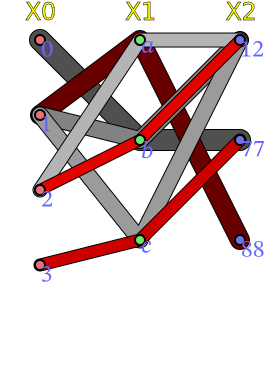

In [10]:
svg = psc.matchings2svg(matchings3d, selected)
SVG(data=svg)

In [11]:
cnf3 = CNF(from_clauses=psc.rand3cnf(3, 6))

In [12]:
from pysat.solvers import Solver

solver = Solver(bootstrap_with=cnf3)
res = solver.solve()
res 

True

In [13]:
print(solver.get_model())

[-1, -2, -3, -4, -5]




| 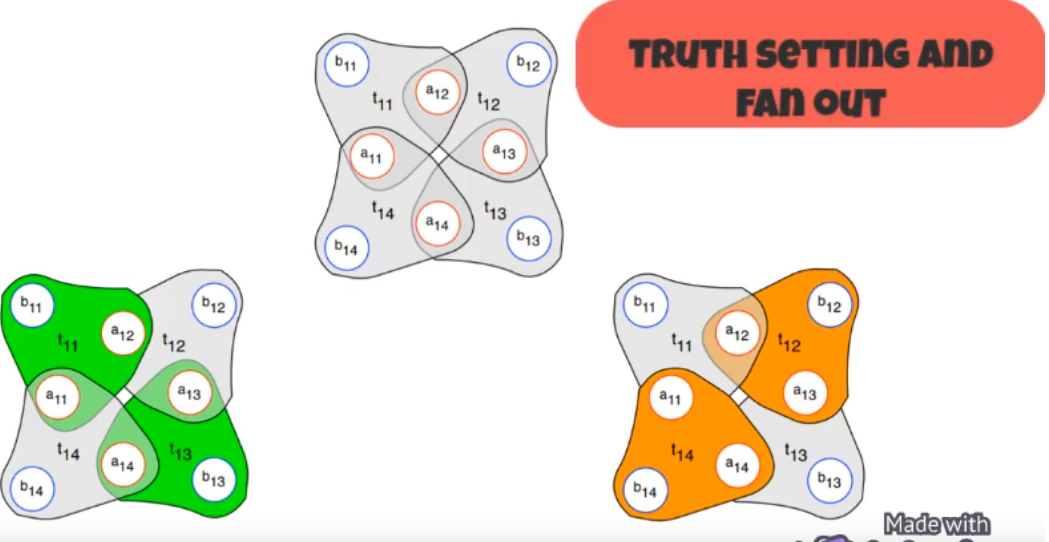 | [видео](https://youtu.be/TtuNf6XMhiw?t=238) |



<img src=".maximum-3-dimensional-matching.ipynb.upload/paste-0.22768987283811892" style="max-width:100%" /> См. [MIT OpenCourseWare](https://youtu.be/eHZifpgyH_4?t=3111)

### [Сведение из википедии](https://en.wikipedia.org/wiki/3-dimensional_matching#Decision_problem) с вариациями
####  Множество $X_0$
* Заводим для каждого упоминания литерала два узла, — сам литерал с номером, какой он по счету (неважно, в каких скобках он был), и его двойник-отрицание.
* Основная логика — какая нода войдет в максимальное сочетание в тройкахе с переменными y-z типа «C» — это и определит присваивание для SAT (так то в максимальное паросочетание войдут все)
  * войдет $x^4_3$, т.е. 4-е упоминание $x_3$ — значит, $x_3=1$
  * войдет $\neg x^2_5$, т.е. отрицательный литерал для 2-го упоминания $x_5$ — значит, $x_5=0$
* Отдельно конечно надо обеспечить, что если вошел $x^4_3$, то должны войти в сочетание и остальные упоминания $x^4_1$, $x^4_2$…  и не должный войти их отрицательные двойники.

####  Множество $X_1$,  $X_2$
* Разные вспомогательные переменные, их смысл будет ниже.



In [14]:
cnf = CNF(from_clauses=psc.rand3cnf(2, 6))

In [15]:
cnf.clauses

[[4, 1, 3], [-2, -4, 1]]

In [16]:
def lit2vertex(cnf, lit, num=None):
    '''
       Отражение литерала в вершину 3д-сопоставления.
       Формула-представление для положительного или отрицательного литерала.
    '''
    n = cnf.nv
    x = abs(lit)
    v = f'x_{{{x}}}'
    if num is not None:
        v = f'x^{{{num}}}_{{{x}}}'
    if lit < 0:
        v = '¬' + v
    return v


### Гаджет «Роза» для каждой скобки
* Соединяем ноды (литерал этой скобки с номером, какой он по порядку)

In [17]:
def clause23dm(cnf, clause_num, with_garbage_collector=True):
    '''
       Скобка КНФ в набор 3d-сочетаний 
    '''
    match = []
    vn2count = Counter()  # счетчик встреч переменной в литералах
    for j, clause in enumerate(cnf.clauses): 
        clause_len = len(clause)
        for lit  in clause:
            vn = abs(lit)      # номер переменной
            vn2count[vn] += 1  # подсчитываем номер переменной по счету.
            if j == clause_num:
                b = lit2vertex(cnf, lit, vn2count[vn])
                match.append([b, f'y_{{c{j}}}', f'z_{{c{j}}}'])
                if with_garbage_collector:
                    for gn in range(clause_len-1):
                        nb = lit2vertex(cnf, -lit, vn2count[vn])
                        match.append([b,  f'y^{{g{j}}}_{{{gn}}}', f'z^{{g{j}}}_{{{gn}}}'])
                        match.append([nb, f'y^{{g{j}}}_{{{gn}}}', f'z^{{g{j}}}_{{{gn}}}'])
    return match

In [18]:
cnf.clauses


[[4, 1, 3], [-2, -4, 1]]

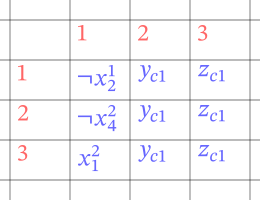

In [19]:
SVG(psc.rows2svgtable(clause23dm(cnf, 1, with_garbage_collector=False)))

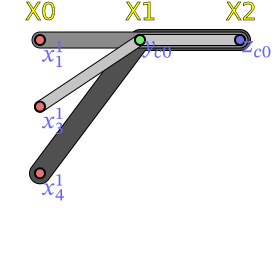

In [20]:
svg = psc.matchings2svg(clause23dm(cnf, 0, with_garbage_collector=False))
SVG(data=svg)

### «Сборка мусора»
Но надо бы покрыть и остальные узлы!

<img src=".maximum-3-dimensional-matching.ipynb.upload/paste-0.10402587724884849" style="max-width:100%" />

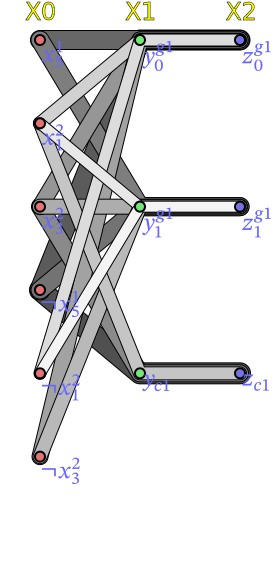

In [21]:
match4clause = clause23dm(cnf3, 1)
SVG(svg1:= psc.matchings2svg(match4clause))

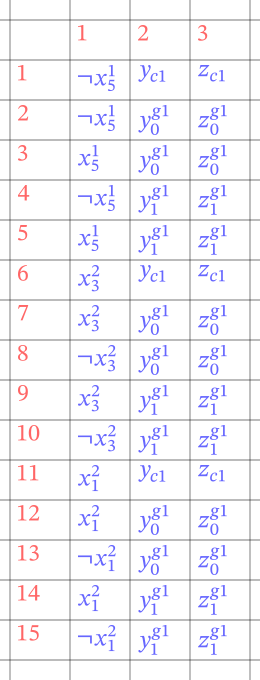

In [22]:
SVG(psc.rows2svgtable(match4clause))

In [23]:
# Не обращать внимание, отладочная ячейка с проблемами, пока не получается две SVG-картинки параллельно вывести.
#no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
#
#display(HTML(no_wrap_div.format(svg1, svg2)))

### Гаджет «Колесо» — сведение переменных

In [24]:
def variable23dm(cnf, var_num):
    '''
    Делаем гаджет колесо для заданной переменной.
    '''
    match = []
    k=0
    for clause in cnf.clauses:
        for lit  in clause:
            if abs(lit)==var_num:
                k += 1    
    n=k
    k=0
    for clause in cnf.clauses:
        for lit  in clause:
            if abs(lit)==var_num:
                vn = abs(lit)
                k += 1    
                bp = lit2vertix(cnf, vn, k)
                bn = lit2vertix(cnf, -vn, k)
                match.append([bp, f'y_{{{vn}}}^{{{k}}}', f'z_{{{vn}}}^{{{k}}}'])
                match.append([bn, f'y_{{{vn}}}^{{{(k % n)+1}}}', f'z_{{{vn}}}^{{{k}}}'])
    return match    

In [25]:
cnf.clauses 

[[4, 1, 3], [-2, -4, 1]]

Да, такое вот, «Колесо»

|<img src=".maximum-3-dimensional-matching.ipynb.upload/paste-0.23409495626151533" style="max-width:100%" />|<img src=".maximum-3-dimensional-matching.ipynb.upload/paste-0.831162896240786" style="max-width:100%" />|<img src=".maximum-3-dimensional-matching.ipynb.upload/paste-0.8835062706683494" style="max-width:100%" />|

In [26]:
m_ = variable23dm(cnf, 2)
SVG(psc.matchings2svg(m_))

NameError: name 'lit2vertix' is not defined

Получится взять либо все «положительные b» либо все отрицательные «b», причем «наоборот» по смыслу.

In [0]:
def sat323dm(cnf):
    m = len(cnf.clauses)
    n = cnf.nv
    matchings = []
    for v in range(1, n+1):
        matchings += variable23dm(cnf, v)
    for j in range(m):
        matchings += clause23dm(cnf, j)
    return matchings


In [0]:
cnf.clauses

[[2, 1, -3], [-2, 1, 1]]

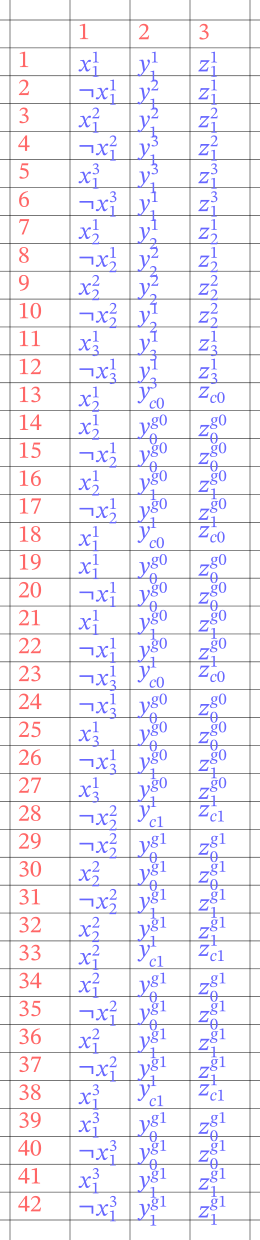

In [0]:
matchings = sat323dm(cnf)
svg = psc.rows2svgtable(matchings)
SVG(data=svg)

In [0]:
m = get_model(matchings)
solver.solve(m).write()
print_solution(m)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12.0
  Upper bound: 12.0
  Number of objectives: 1
  Number of constraints: 29
  Number of variables: 42
  Number of binary variables: 42
  Number of integer variables: 42
  Number of nonzeros: 42
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.02
  Wallclock time: 0.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

In [0]:
R = [e for j, e in enumerate(m.E) if m.x[e].value > 0]

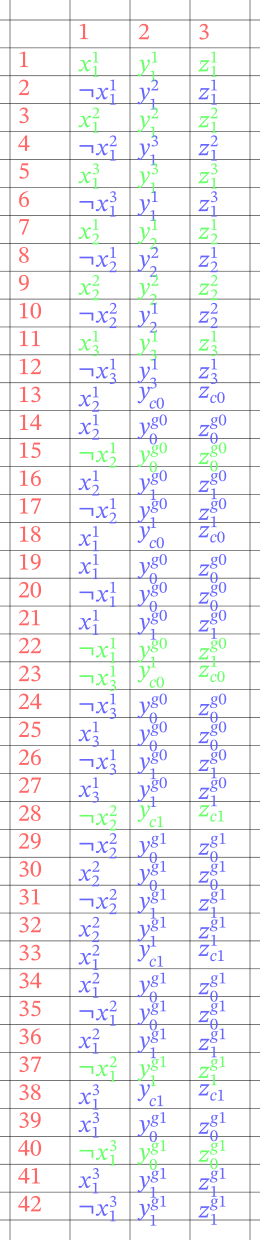

In [0]:
R = [e for j, e in enumerate(m.E) if m.x[e].value > 0]
S = [j for j, e in enumerate(m.E) if m.x[e].value > 0]

#svg = psc.matchings2svg(matchings, selected=R)
SVG(psc.rows2svgtable(m.E, selected_rows=S))



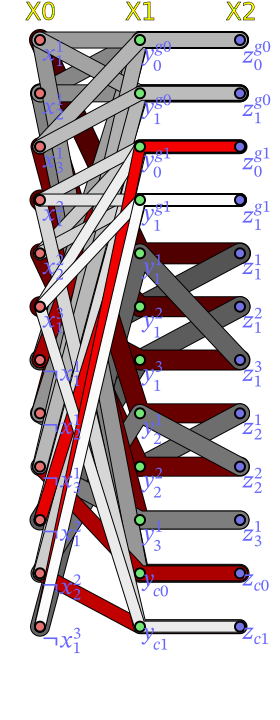

In [0]:
S = [j for j, e in enumerate(m.E) if m.x[e].value > 0]
svg = psc.matchings2svg(matchings, selected=S)
SVG(data=svg)

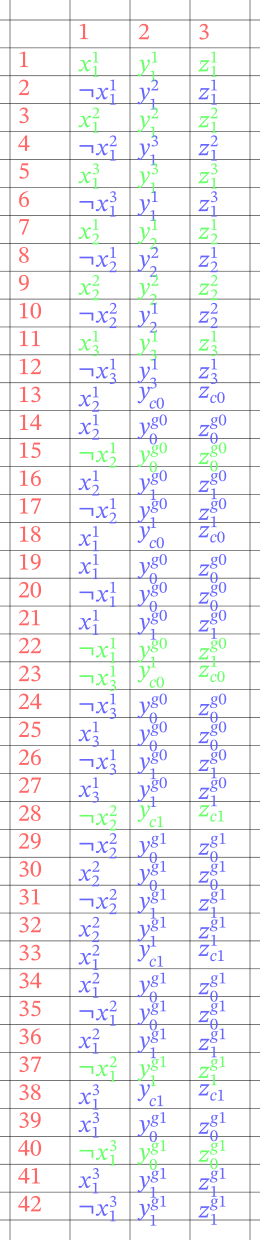

In [0]:

svg = psc.rows2svgtable(matchings, selected_rows=S)
SVG(data=svg)


In [0]:
matchings


[['x^{1}_{1}', 'y_{1}^{1}', 'z_{1}^{1}'],
 ['¬x^{1}_{1}', 'y_{1}^{1}', 'z_{1}^{1}'],
 ['x^{2}_{1}', 'y_{1}^{2}', 'z_{1}^{2}'],
 ['¬x^{2}_{1}', 'y_{1}^{0}', 'z_{1}^{2}'],
 ['x^{1}_{2}', 'y_{2}^{1}', 'z_{2}^{1}'],
 ['¬x^{1}_{2}', 'y_{2}^{1}', 'z_{2}^{1}'],
 ['x^{2}_{2}', 'y_{2}^{2}', 'z_{2}^{2}'],
 ['¬x^{2}_{2}', 'y_{2}^{0}', 'z_{2}^{2}'],
 ['x^{1}_{3}', 'y_{3}^{1}', 'z_{3}^{1}'],
 ['¬x^{1}_{3}', 'y_{3}^{1}', 'z_{3}^{1}'],
 ['x^{2}_{3}', 'y_{3}^{2}', 'z_{3}^{2}'],
 ['¬x^{2}_{3}', 'y_{3}^{0}', 'z_{3}^{2}'],
 ['x^{1}_{1}', 'y_{c0}', 'z_{c0}'],
 ['x^{1}_{1}', 'y^{g0}_{0}', 'z^{g0}_{0}'],
 ['¬x^{1}_{1}', 'y^{g0}_{0}', 'z^{g0}_{0}'],
 ['x^{1}_{1}', 'y^{g0}_{1}', 'z^{g0}_{1}'],
 ['¬x^{1}_{1}', 'y^{g0}_{1}', 'z^{g0}_{1}'],
 ['x^{1}_{2}', 'y_{c0}', 'z_{c0}'],
 ['x^{1}_{2}', 'y^{g0}_{0}', 'z^{g0}_{0}'],
 ['¬x^{1}_{2}', 'y^{g0}_{0}', 'z^{g0}_{0}'],
 ['x^{1}_{2}', 'y^{g0}_{1}', 'z^{g0}_{1}'],
 ['¬x^{1}_{2}', 'y^{g0}_{1}', 'z^{g0}_{1}'],
 ['x^{1}_{3}', 'y_{c0}', 'z_{c0}'],
 ['x^{1}_{3}', 'y^{g0}_{0}

In [0]:
def matchsol2cnfsol(m):
    '''
    Конвертируем ЦЛП-решение для matchings в присваивания для CNF
    '''
    import re
    cnfsol = {}
    re_ = re.compile(r"(?P<neg>¬)?x\^\{\d+\}\_\{(?P<varn>\d+)\}")
    
    for e in m.E:
        if m.x[e].value > 0:
            if 'c' in e[2]:
                rm = re_.match(e[0])
                assert rm, e[0]
                varn = int(rm.group("varn"))
                val = 1
                if rm.group("neg"):
                    val = 0
                assert varn not in cnfsol or val == cnfsol[varn], (e, cnfsol[varn])
                cnfsol[varn] = val
    return cnfsol        

In [0]:
cnf.clauses

[[2, 1, -3], [-2, 1, 1]]

In [0]:
matchings = sat323dm(cnf)
m = get_model(matchings)
solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12.0
  Upper bound: 12.0
  Number of objectives: 1
  Number of constraints: 24
  Number of variables: 42
  Number of binary variables: 42
  Number of integer variables: 42
  Number of nonzeros: 42
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 


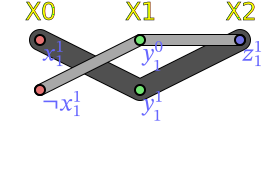

In [0]:
SVG(psc.matchings2svg(variable23dm(cnf, 1)))

In [0]:
print_solution(m)

x[¬x^{1}_{1},y_{1}^{0},z_{1}^{1}] 1.0
x[x^{1}_{2},y_{2}^{1},z_{2}^{1}] 1.0
x[x^{1}_{3},y_{3}^{1},z_{3}^{1}] 1.0
x[x^{1}_{4},y_{4}^{1},z_{4}^{1}] 1.0
x[¬x^{2}_{4},y_{4}^{0},z_{4}^{2}] 1.0
x[¬x^{1}_{5},y_{5}^{0},z_{5}^{1}] 1.0
x[¬x^{1}_{2},y_{c0},z_{c0}] 1.0
x[¬x^{1}_{4},y^{g0}_{0},z^{g0}_{0}] 1.0
x[x^{1}_{1},y^{g0}_{1},z^{g0}_{1}] 1.0
x[x^{2}_{4},y_{c1},z_{c1}] 1.0
x[¬x^{1}_{3},y^{g1}_{1},z^{g1}_{1}] 1.0
x[x^{1}_{5},y^{g1}_{0},z^{g1}_{0}] 1.0


In [0]:

matchsol2cnfsol(m)

{2: 0, 4: 1}

In [0]:
def solve_cnf_by_3dm(cnf):
    matchings = sat323dm(cnf)
    m = get_model(matchings)
    solver.solve(m)   
    sol = matchsol2cnfsol(m)
    return sol    

In [0]:
cnf = CNF(from_clauses=psc.rand3cnf(16, 9))
cnf.clauses, solve_cnf_by_3dm(cnf)

([[-3, -6, -2],
  [-3, 7, 1],
  [8, -3, 1],
  [5, 2, -1],
  [-2, 3, 7],
  [-3, -7, 1],
  [-5, -8, -2],
  [3, -4, 7],
  [-1, 1, 2],
  [3, 1, 6],
  [-1, 6, 3],
  [-1, 6, 5],
  [4, -1, -8],
  [4, -2, 5],
  [-1, 7, 8],
  [-5, -2, -1]],
 {3: 0, 7: 1, 1: 0, 8: 0, 2: 1, 6: 1, 4: 1, 5: 0})